In [486]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import regularizers
from keras import backend as K
from keras import Sequential, Input
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import math
from functools import partial

In [487]:
# make the result reproducible
keras.utils.set_random_seed(42)

In [488]:
K.clear_session()

In [489]:
physical_devices = tf.config.list_physical_devices()
CLASSES = 48
IMAGE_SIZE = 24

print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [490]:
# tf.config.set_visible_devices(physical_devices[1], 'GPU')

## Building Dataset

### Attributes description

- a1 - face containing flag: (1-with face, 0-without face),
- a2 - image number in current class (person) beginning from 0,
- a3 - class (person) number beginning from 0,
- a4 - sex (0 - woman, 1 - man)
- a5 - race (0- white, 1 - negro, 2 - indian, ...)
- a6 - age (0 - baby, 1 - young, 2 - middle-age, 3 - old) 
- a7 - binokulars (0 - without, 1 - transparent, 2 - dark)
- a8 - emotional expression (not state!) (0 - sad, 1 - neutral, 2 - happy)

In [491]:
def read_file(filename):
  
  with open(filename, 'r') as file:
    file.readline() # we skip the first line as it is not needed
    number_of_pixels = int(file.readline())

    features = []
    labels = []

    for line in file.readlines():
      elements = line.split()

      # add features
      pixels = np.array(elements[:number_of_pixels], dtype=float)
      pixels = np.reshape(pixels, [IMAGE_SIZE, IMAGE_SIZE])
      features.append(pixels)

      # add labels
      labels.append(elements[number_of_pixels+2])

    features = np.array(features)
    labels = np.array(labels, dtype=int)

  return features, labels

In [492]:
# classes 0-15
X_0, y_0 = read_file('./data/x24x24.txt')
# classes 16-31
X_1, y_1 = read_file('./data/y24x24.txt')
# # classes 32-48
X_2, y_2 = read_file('./data/z24x24.txt')

print(len(X_0), len(y_0))
print(len(X_1), len(y_1))
print(len(X_2), len(y_2))

2321 2321
2208 2208
2306 2306


In [493]:
# Concatenate train and test images
X = np.concatenate((X_0, X_1, X_2))
y = np.concatenate((y_0, y_1, y_2))
print(len(X), len(y))

N_TRAIN_EXAMPLES=int(len(X) * 0.8)
N_TEST_EXAMPLES=len(X) - N_TRAIN_EXAMPLES


X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, train_size=N_TRAIN_EXAMPLES, 
                                                            test_size=N_TEST_EXAMPLES, random_state=42)

# One-Hot encoding
# Getting dummy variables
y_train = np.zeros((y_train_raw.shape[0], CLASSES))
y_test = np.zeros((y_test_raw.shape[0], CLASSES))

for i, value in enumerate(y_train_raw):
  y_train[i][value] = 1
  
for i, value in enumerate(y_test_raw):
  y_test[i][value] = 1

6835 6835


In [494]:
print(len(X_train))

5468


## Building a model

Testing LeNet-5 Architecture

In [495]:
conv_regularizer = regularizers.l2(0.0006)
dense_regularizer = regularizers.l2(0.01)

# conv_regularizer = regularizers.l2(0)
# dense_regularizer = regularizers.l2(0)

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=5, padding="same", activation="tanh",
                        kernel_initializer="he_normal")
                        # kernel_regularizer=conv_regularizer)

model = keras.Sequential(
  [
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    DefaultConv2D(filters=6),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Dropout(0.15),
    DefaultConv2D(filters=16),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Dropout(0.25),
    DefaultConv2D(filters=120),
    
    layers.Flatten(),
    layers.Dropout(0.35),
    # layers.Dense(84, activation='relu', kernel_regularizer=dense_regularizer),
    layers.Dense(84, activation='relu'),
    layers.Dense(CLASSES, activation='softmax'),
  ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4320)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4320)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 84)             │       362,964 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         4,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,736 (1.59 MB)

 Trainable params: 417,736 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

In [496]:
# def get_lr_metric(optimizer):
#   def lr(y_true, y_pred):
#     return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
#   return lr


# optimizer = Adam(learning_rate=0.00025)
optimizer = Adam(learning_rate=0.001)

# lr_metric = get_lr_metric(optimizer)
# model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=["accuracy", lr_metric])
model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=["accuracy"])

In [497]:
def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.9
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop,  
          math.floor((1+epoch)/epochs_drop))
  return lrate
 
lrate_scheduler_callback = LearningRateScheduler(step_decay)

## Training Preparation

In [498]:
CHECKPOINT_PATH = 'models/checkpoints/famous48_test_model_v2_best.keras'

In [499]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=CHECKPOINT_PATH,
  save_weights_only=False,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True,
)

In [500]:
%%time
batch_size = 200
epochs = 20

# K.set_value(model.optimizer.learning_rate, 0.0005)

history = model.fit(
  X_train, y_train,
  batch_size=batch_size,
  epochs=epochs,
  validation_split=0.2,
  shuffle=True,
  # callbacks=[model_checkpoint_callback, lrate_scheduler_callback]
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0365 - loss: 3.9633 - val_accuracy: 0.1207 - val_loss: 3.6783
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0961 - loss: 3.6634 - val_accuracy: 0.1682 - val_loss: 3.2362
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2046 - loss: 3.1354 - val_accuracy: 0.3547 - val_loss: 2.4360
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3445 - loss: 2.4500 - val_accuracy: 0.4781 - val_loss: 1.8573
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4787 - loss: 1.9116 - val_accuracy: 0.5923 - val_loss: 1.5043
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5502 - loss: 1.5898 - val_accuracy: 0.6316 - val_loss: 1.3069
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6122 - loss: 1.3626 - val_accuracy: 0.6517 - val_loss: 1.1867
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6510 - loss: 1.2117 - val_accuracy: 0.6993 - v

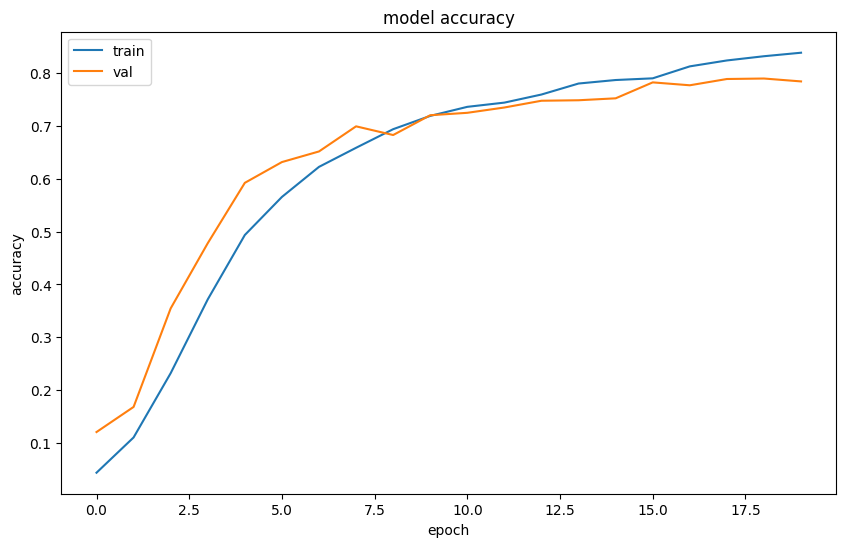

In [501]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [502]:
length = len(history.history['accuracy'])
print("train set accuracy:", round(history.history['accuracy'][length-1], 2))
print("validation set accuracy:", round(history.history['val_accuracy'][length-1], 2))

train set accuracy: 0.84
validation set accuracy: 0.78


In [503]:
# model.load_weights("models/checkpoints/famous48_test_model_v2_best.keras")
results = model.evaluate(X_test, y_test)
print("test set accuracy:", round(results[1], 2))

 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8438 - loss: 0.7233

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8108 - loss: 0.6846
test set accuracy: 0.81
